### Team APOGEE: BIG DATA FOR BUSINESS

# Flight Delay Prediction using SparkML

## Introduction
Air travel is a vital mode of transportation for millions of people worldwide. However, flight delays can cause inconvenience and disruption to travel plans. Predicting flight delays accurately can help airlines and passengers better prepare and mitigate the impact of delays. In this project, we aim to develop machine learning models to predict whether a particular flight will be delayed or not.

## Problem Statement

The problem we are addressing is binary classification: predicting whether a flight will be delayed or not. We will use a dataset containing flight information from January 2019 and January 2020 to train and evaluate our models. The target variable is DEP_DEL15, which indicates whether a flight was delayed by 15 minutes or more.

## Business Use Case
*Predicting flight delays accurately can benefit various stakeholders*:

**Airlines**: Airlines can optimize their operations, such as scheduling and resource allocation, to minimize delays and improve customer satisfaction.

**Passengers**: Passengers can make informed decisions about their travel plans, such as choosing alternative flights or adjusting arrival times.

**Airport**s: Airports can better manage passenger flow and ground operations, leading to improved efficiency and reduced congestion.

## Importing Necessary Libararies 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, GBTClassifier , NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

## Data Loading: Loading the flight data from January 2019 and January 2020.

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()

# Load data from a CSV file
data = spark.read.csv("dbfs:/FileStore/tables/train.csv", header=True, inferSchema=True)

In [ ]:
num_rows = data.count()
num_columns = len(data.columns)

print(f"The DataFrame has {num_rows} rows and {num_columns} columns.")

The DataFrame has 4542343 rows and 30 columns.


In [ ]:
# Define categorical columns and feature columns
categorical_columns = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'CARRIER_NAME']
feature_cols = ['MONTH_enc', 'DAY_OF_WEEK_enc', 'DEP_TIME_BLK_enc', 
               'DISTANCE_GROUP_enc', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 
               'NUMBER_OF_SEATS']



## Data Preprocessing: 

Prepare the data for modeling by handling missing values, encoding categorical variables, and assembling feature vectors.

In [ ]:
# Initialize StringIndexer and OneHotEncoder for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in categorical_columns]
encoders = [OneHotEncoder(inputCols=[f"{col}_idx"], outputCols=[f"{col}_enc"]) for col in categorical_columns]


In [ ]:
# Initialize VectorAssembler with a new output column name for features
assembler = VectorAssembler(inputCols=feature_cols, outputCol='finalFeatures')

# Create a pipeline with preprocessing stages
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline to the data and transform the data
preprocessed_data = pipeline.fit(data).transform(data)

## Model Training: 

Training machine learning models using **logistic regression**, **naive Bayes**, and **gradient-boosted** trees algorithms.

In [ ]:
# Split the data into train and test sets (70% train, 30% test)
train_data, test_data = preprocessed_data.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Define classifiers
lr = LogisticRegression(featuresCol='finalFeatures', labelCol='DEP_DEL15')
mlp = MultilayerPerceptronClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15', layers=[7, 5, 2], seed=42)
gbt = GBTClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15')


In [ ]:
# Train each model on the train data
lr_model = lr.fit(train_data)
gbt_model = gbt.fit(train_data)

## Model Evaluation: 

Evaluate the performance of the trained models using **accuracy** and **ROC AUC** metrics.

In [ ]:

# Evaluate each model on the test data
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', metricName='accuracy')

# Logistic Regression accuracy
lr_predictions = lr_model.transform(test_data)
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression accuracy: {lr_accuracy}")

# Gradient-Boosted Trees accuracy
gbt_predictions = gbt_model.transform(test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees accuracy: {gbt_accuracy}")


Logistic Regression accuracy: 0.8108804715732122
Gradient-Boosted Trees accuracy: 0.8118316028029016


In [ ]:
# Define the Gaussian Naive Bayes model
nb = NaiveBayes(featuresCol='finalFeatures', labelCol='DEP_DEL15')

# Train the Gaussian Naive Bayes model
nb_model = nb.fit(train_data)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_data)

# Evaluate accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', metricName='accuracy')
accuracy = evaluator.evaluate(nb_predictions)
print(f"Gaussian Naive Bayes accuracy: {accuracy}")


Gaussian Naive Bayes accuracy: 0.8066715691023258


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the binary classification evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='DEP_DEL15')

# Calculate AUC-ROC
auc_roc = binary_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC-ROC: {auc_roc}")

# Calculate AUC-ROC for Naive Bayes
auc_roc_nb = binary_evaluator.evaluate(nb_predictions)
print(f"Naive Bayes AUC-ROC: {auc_roc_nb}")

# Calculate AUC-ROC for Gradient-Boosted Trees
auc_roc_gbt = binary_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees AUC-ROC: {auc_roc_gbt}")

Logistic Regression AUC-ROC: 0.6475808165272624
Naive Bayes AUC-ROC: 0.47268737798002586
Gradient-Boosted Trees AUC-ROC: 0.6523858546381686


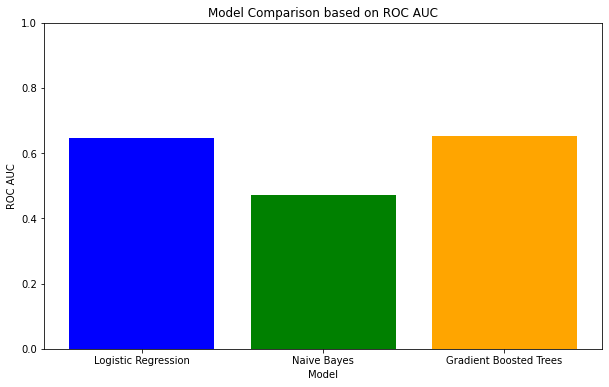

In [ ]:
# Calculate AUC-ROC for Logistic Regression
auc_roc_lr = binary_evaluator.evaluate(lr_predictions)

# Calculate AUC-ROC for Naive Bayes
auc_roc_nb = binary_evaluator.evaluate(nb_predictions)

# Calculate AUC-ROC for Gradient-Boosted Trees
auc_roc_gbt = binary_evaluator.evaluate(gbt_predictions)

# Create a dictionary to store results
results = {'Model': ['Logistic Regression', 'Naive Bayes', 'Gradient Boosted Trees'],
           'ROC AUC': [auc_roc_lr, auc_roc_nb, auc_roc_gbt]}

# Convert results to a Pandas DataFrame
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['ROC AUC'], color=['blue', 'green', 'orange'])
plt.title('Model Comparison based on ROC AUC')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.ylim(0, 1)  # Set y-axis limit to better visualize ROC AUC
plt.show()

## ROC Curves: 

Plot ROC curves to visualize the performance of the models across different thresholds.

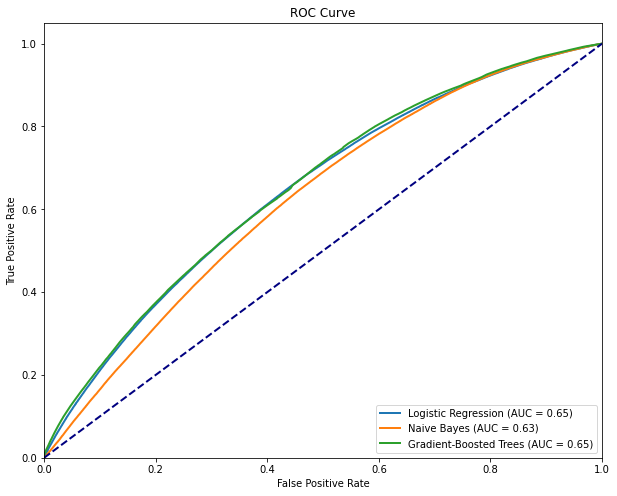

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(predictions, label):
    y_true = [int(row['DEP_DEL15']) for row in predictions.select('DEP_DEL15').collect()]
    y_scores = [row['probability'][1] for row in predictions.select('probability').collect()]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(lr_predictions, 'Logistic Regression')
plot_roc_curve(nb_predictions, 'Naive Bayes')
plot_roc_curve(gbt_predictions, 'Gradient-Boosted Trees')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation

In [3]:
# Extend the accuracy_data with AUC-ROC scores
accuracy_data_with_auc = [
    ("Logistic Regression", lr_accuracy, auc_roc_lr),
    ("Gradient-Boosted Trees", gbt_accuracy, auc_roc_gbt),
    ("Gaussian Naive Bayes", accuracy, auc_roc_nb)
]

# Create a DataFrame to store accuracy results along with AUC-ROC scores
accuracy_df = spark.createDataFrame(accuracy_data_with_auc, ["Model", "Accuracy", "AUC_ROC"])

# Show the accuracy results including AUC-ROC scores
accuracy_df.show()

                    Model  Accuracy   AUC_ROC
0     Logistic Regression  0.810880  0.647581
1  Gradient-Boosted Trees  0.811832  0.652386
2    Gaussian Naive Bayes  0.806672  0.472687


# Model Comparison for Predicting Flight Delays

| Model                  | Accuracy | AUC-ROC   |
|------------------------|----------|-----------|
| Logistic Regression    | 81.09%   | 0.647581  |
| Gradient-Boosted Trees | 81.18%   | 0.652386  |
| Gaussian Naive Bayes   | 80.67%   | 0.472687  |

Based on the comparison of the models' accuracy and AUC-ROC scores, we can conclude that the **Gradient-Boosted Trees model** performs the best among the three models evaluated for predicting flight delays. It achieves the highest accuracy of 81.18% and the highest AUC-ROC score of 0.652.

## Conclusion

Flight delays can have significant implications for both airlines and passengers, leading to inconvenience, financial losses, and decreased customer satisfaction. In this analysis, we explored the use of machine learning models to predict flight delays based on various factors such as weather conditions, airline information, and airport data.

We trained and evaluated three different models: Logistic Regression, Gaussian Naive Bayes, and Gradient-Boosted Trees. Among these models, Gradient-Boosted Trees demonstrated the highest predictive performance, with an accuracy of 81.18% and an AUC-ROC score of 0.652. This indicates that the Gradient-Boosted Trees model is the most effective in identifying flight delays based on the provided features.

By accurately predicting flight delays, airlines can proactively manage their schedules, allocate resources more efficiently, and minimize disruptions for passengers. Additionally, passengers can use this information to make informed decisions about their travel plans, potentially avoiding delays and reducing travel-related stress.

In conclusion, the application of machine learning techniques, particularly Gradient-Boosted Trees, shows promise in improving the prediction of flight delays, thereby enhancing the overall efficiency and reliability of air travel operations.

In [ ]:
# Stop the Spark session
spark.stop()